Unveiling Business Insights from Western vs. Russian War-related Tweets

This file has been run in Colab. For the file to run properly, please upload csv rouble_exchange_rate, western_analysts_tweets and russian_propaganda_tweets into the session for the pd_read.csv commands to work.

The pip install lines need to be run only once.

Please also note that the pictures for ROC curve, learning curve, df_w, df_r and merged_df are also being saved only in the Colab session and need to be downloaded if needed for the future.

Also note that for BERT we include a separate code for Ucloud, where it runs faster, however it works here in Colab too.

The file is organized as:
1. data preprocessing
2. LDA with TF IDF
3. Logistic regression
4. Sentiment analysis
5. Topic modelling with BERTopic

# Data Pre-processing

In [ ]:
# Importing all the necessary packages
import pandas as pd
import numpy as np
import nltk
import string
import re
import gensim
import random

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words as nltk_words


from multiprocessing import cpu_count

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# please change the file path accordingly to your needs

df_w=pd.read_csv('/content/western_analysts_tweets.csv', encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING

df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16727 entries, 0 to 16726
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16727 non-null  float64
 1   conversation_id  16727 non-null  float64
 2   created_at       16727 non-null  object 
 3   date             16727 non-null  object 
 4   time             16727 non-null  object 
 5   timezone         16727 non-null  int64  
 6   user_id          16727 non-null  float64
 7   username         16727 non-null  object 
 8   name             16727 non-null  object 
 9   place            531 non-null    object 
 10  tweet            16727 non-null  object 
 11  language         16727 non-null  object 
 12  mentions         16727 non-null  object 
 13  urls             16727 non-null  object 
 14  photos           16727 non-null  object 
 15  replies_count    16727 non-null  int64  
 16  retweets_count   16727 non-null  int64  
 17  likes_count 

In [ ]:
df_r=pd.read_csv('/content/russian_propaganda_tweets.csv' ,encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING
#some of the columns were causing issues so they were already removed in the csv file
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22602 entries, 0 to 22601
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               22602 non-null  float64
 1   conversation_id  22602 non-null  float64
 2   created_at       22602 non-null  object 
 3   date             22602 non-null  object 
 4   time             22602 non-null  object 
 5   tweet            22602 non-null  object 
 6   tweet.1          22602 non-null  object 
 7   retweets_count   22602 non-null  int64  
 8   likes_count      22602 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


We can see that for Russian dataset we have a bit more values (22602 compared to 16727 for the Western dataset). So there is a slight imbalance, which might impact the result from the classifier later on.

In [ ]:
#Keeping only the important columns (likes_count and retweets_count used only for sentiment analysis later on)
columns_to_keep = ['created_at', 'tweet', 'likes_count','retweets_count']
df_w = df_w[columns_to_keep]
df_r = df_r[columns_to_keep]

df_w.head()

created_at  \
0  2022-02-24 02:01:32 GTB Standard Time   
1  2022-02-24 02:02:33 GTB Standard Time   
2  2022-02-24 02:03:39 GTB Standard Time   
3  2022-02-24 02:15:19 GTB Standard Time   
4  2022-02-24 02:19:59 GTB Standard Time   

                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  
0              40  
1              28  
2              17  
3             123  
4             180

In [ ]:
df_r.head()

created_at  \
0  2022-02-24 14:01:58 GTB Standard Time   
1  2022-02-24 14:24:32 GTB Standard Time   
2  2022-02-24 14:42:53 GTB Standard Time   
3  2022-02-24 14:50:06 GTB Standard Time   
4  2022-02-24 14:56:54 GTB Standard Time   

                                               tweet  likes_count  \
0                            https://t.co/4dVHUFQVd4           58   
1  ?? President Vladimir Putin: We have to take b...         1243   
2  ?? Vladimir Putin: Over the past 30 years we h...         2881   
3  President #Putin: For 8 years Russia has been ...          904   
4  ?? Vladimir Putin: A veritable empire of lies...         2016   

   retweets_count  
0               5  
1             315  
2             946  
3             281  
4             668

In [ ]:
#Adding additional column representing whether the post is from Russian perspective or not (0 for western persepective, 1 for Russian)
df_w = df_w.assign(Label=0)
df_r = df_r.assign(Label=1)

In [ ]:
# From the date column, keep only the date info, and create a new column which keeps only the month info

df_w['date'] = df_w['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())
df_r['date'] = df_r['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())

df_w['month'] = pd.to_datetime(df_w['date'])
df_w['month'] = df_w['month'].dt.month

df_r['month'] = pd.to_datetime(df_r['date'])
df_r['month'] = df_r['month'].dt.month

print(df_w.head())

                              created_at  \
0  2022-02-24 02:01:32 GTB Standard Time   
1  2022-02-24 02:02:33 GTB Standard Time   
2  2022-02-24 02:03:39 GTB Standard Time   
3  2022-02-24 02:15:19 GTB Standard Time   
4  2022-02-24 02:19:59 GTB Standard Time   

                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  
0              40      0  2022-02-24      2  
1              28      0  2022-02-24      2  
2              17      0  2022-02-24      2  
3             123      0  2022-02-24      2  
4             180      0  2022-02-24      2  


In [ ]:
df_r.drop('created_at',axis=1,inplace=True) #this column is no longer needed
df_r.head()

tweet  likes_count  \
0                            https://t.co/4dVHUFQVd4           58   
1  ?? President Vladimir Putin: We have to take b...         1243   
2  ?? Vladimir Putin: Over the past 30 years we h...         2881   
3  President #Putin: For 8 years Russia has been ...          904   
4  ?? Vladimir Putin: A veritable empire of lies...         2016   

   retweets_count  Label        date  month  
0               5      1  2022-02-24      2  
1             315      1  2022-02-24      2  
2             946      1  2022-02-24      2  
3             281      1  2022-02-24      2  
4             668      1  2022-02-24      2

In [ ]:
df_w.drop('created_at',axis=1, inplace=True) #this column is no longer needed
df_w.head()

tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  
0              40      0  2022-02-24      2  
1              28      0  2022-02-24      2  
2              17      0  2022-02-24      2  
3             123      0  2022-02-24      2  
4             180      0  2022-02-24      2

In [ ]:
print(df_r.value_counts('month'))
print(df_w.value_counts('month'))

month
4    9722
3    8960
5    2308
2    1612
Name: count, dtype: int64
month
3    7501
4    6179
2    1780
5    1267
Name: count, dtype: int64


With the dates, we can again see there will be some imbalance, as the majority of the tweets are in months 3 and 4, March and April.

In [ ]:
#Checking for missing values
print(df_w.isnull().sum())
print(df_r.isnull().sum())

# No missing values in the datasets

tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64
tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64


In [ ]:
#Checking for the duplicates, but we are keeping the first values as we dont want to remove these

duplicates_count_r = df_r.duplicated(keep='first')
print(duplicates_count_r.sum())

df_r.drop_duplicates(keep='first', inplace=True)


5


In [ ]:
duplicates_count_w = df_w.duplicated(keep='first')
print(duplicates_count_w.sum())

df_w.drop_duplicates(keep='first', inplace=True)


5


In [ ]:
#Preprocess and clean the tweets column

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    custom_stopwords = {
    "war", "via", "http", "https", "www", "com", "bit", "ly", "amp", 'another',
    "get", "like", "just", "say", "says", "said", "will", "new", "now", "today", 'make', 'made',
    'russian','russia','ukraine','ukrainian',
    'would', 'will', 'exactly', 'know','going','like','thing',
}

    def clean_text(text):
        # Remove URLs
        text = re.sub(r"https?://\S+", "", text)
        # Remove non-alphanumeric characters and extra whitespaces
        text = re.sub(r"[^a-zA-Z\s']", " ", text)
        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text)
        # Remove hashtags (words starting with #)
        text = re.sub(r"#\w+", "", text)
        # Remove mentions (words starting with @)
        text = re.sub(r"@\w+", "", text)
        # Remove punctuation and special characters (excluding apostrophes)
        text = re.sub(r"[^\w\s']", "", text)
        # Remove newline characters
        text = re.sub(r"[\n\r]", " ", text)
        # Convert to lowercase
        text = text.lower()
        return text

    cleaned_text = clean_text(text)

    tokens = word_tokenize(cleaned_text)

    # Additionally remove stopwords, punctuation, custom stopwords, and lemmatize
    new_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w not in punctuation and w not in custom_stopwords and len(w) > 3]

    return (new_tokens)

cleaned_tokens_w = df_w['tweet'].apply(preprocess_text)
cleaned_tokens_r = df_r['tweet'].apply(preprocess_text)

print(cleaned_tokens_w.head(10))
print(cleaned_tokens_r.head(10))

0    [security, council, hold, emergency, session, ...
1                           [kyiv, time, urgent, year]
2               [rare, meeting, unsc, time, requested]
3    [turkish, force, airbus, entered, airspace, lo...
4    [cyber, attack, targeting, website, security, ...
5    [secretary, state, blinken, belief, invade, ni...
6      [clash, audible, night, mariupol, herooftheday]
7    [blinken, doubling, security, diplomatic, huma...
8    [landed, czech, republic, practicing, quick, t...
9    [israeli, civilian, aircraft, flying, western,...
Name: tweet, dtype: object
0                                                   []
1    [president, vladimir, putin, take, bold, immed...
2    [vladimir, putin, past, year, patiently, tryin...
3    [president, putin, year, everything, possible,...
4    [vladimir, putin, veritable, empire, lie, crea...
5                            [asbmilitary, good, luck]
6    [president, putin, asked, help, decision, carr...
7    [border, guard, crossed, bryansk,

In [ ]:
#Appending these cleaned tokens back to the dataframe

df_w['cleaned_tokens'] = df_w['tweet'].apply(preprocess_text)
df_r['cleaned_tokens'] = df_r['tweet'].apply(preprocess_text)

## Create BOW representations of words for both datasets

In [ ]:
%pip install pandas==1.5.3 #needed for the plotting of LDA, run it only once
%pip install pyLDAvis
%pip install pyLDAvis.gensim
%pip install vaderSentiment

  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [ ]:
import gensim

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore

In [ ]:
# Create a Dictionary object which is mapping unique word tokens to unique IDs
dictionary_w = corpora.Dictionary(cleaned_tokens_w)
print(len(dictionary_w.values()))

dictionary_r = corpora.Dictionary(cleaned_tokens_r)
print(len(dictionary_r.values()))

16807
23742


In [ ]:
#Filter out those words tokens that appear in less than 25 documents and more than half of the documents

dictionary_w.filter_extremes(no_below=25, no_above=0.5)
print(len(dictionary_w.iteritems()))

dictionary_r.filter_extremes(no_below=25, no_above=0.5)
print(len(dictionary_r.iteritems()))

1303
1483


In [ ]:
# Convert the list with tokenized tweets to BOW representation based on the created dictionary

bow_corpus_w = [dictionary_w.doc2bow(tokens) for tokens in cleaned_tokens_w]
bow_corpus_r = [dictionary_r.doc2bow(tokens) for tokens in cleaned_tokens_r]

In [ ]:
#Preview some of the BOW representations to get the idea of the format

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_w[i]))

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_r[i]))

Document 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
Document 2: [(6, 1), (7, 1), (8, 1)]
Document 3: [(7, 1), (9, 1), (10, 1)]
Document 4: [(6, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]
Document 5: [(5, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
Document 1: []
Document 2: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
Document 3: [(11, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
Document 4: [(5, 1), (9, 1), (10, 1), (11, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]
Document 5: [(11, 1), (15, 1), (21, 1), (29, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]


In [ ]:
#Append the BOW into separate col in our dataframes

bow_scores_w = [dict(doc) for doc in bow_corpus_w]
bow_scores_r = [dict(doc) for doc in bow_corpus_r]

df_w['bow_scores'] = bow_scores_w
df_r['bow_scores'] = bow_scores_r

## Create TF IDF representation from the BOW corpus


In [ ]:
#setting seed for reproducibility

np.random.seed(42)
random.seed(42)

In [ ]:
#TF IDF is a more accurate and precise representation than BOW

tfidf_w = models.TfidfModel(bow_corpus_w)
tfidf_r = models.TfidfModel(bow_corpus_r)

In [ ]:
corpus_tfidf_w = tfidf_w[bow_corpus_w]
corpus_tfidf_r = tfidf_r[bow_corpus_r]

In [ ]:
# Convert the TF-IDF representations into a list of dictionaries where each dictionary represents TF-IDF scores for a document
tfidf_scores_w = [dict(corpus_tfidf_w[i]) for i in range(len(corpus_tfidf_w))]
tfidf_scores_r = [dict(corpus_tfidf_r[i]) for i in range(len(corpus_tfidf_r))]

# Append the TF-IDF scores as a separate column in the DataFrame
df_w['tfidf_scores'] = tfidf_scores_w
df_r['tfidf_scores'] = tfidf_scores_r


print(df_w.head())
print(df_r.head())


                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  \
0              40      0  2022-02-24      2   
1              28      0  2022-02-24      2   
2              17      0  2022-02-24      2   
3             123      0  2022-02-24      2   
4             180      0  2022-02-24      2   

                                      cleaned_tokens  \
0  [security, council, hold, emergency, session, ...   
1                         [kyiv, time, urgent, year]   
2             [rare, meeting, unsc, time, requested]   
3  [turkish, force, airbus, entered, airspace, lo...   
4  [cyber, attack, tar

## Saving the cleaned datasets





In [ ]:
#Save this dataframe view as new csv for easier reuse
#Note that this saves the df into the session in colab - you need to download the csv for reusal

df_w.to_csv('df_w.csv', index=False)
df_r.to_csv('df_r.csv', index=False)

In [ ]:
# Also produce a merged dataframe of the both
merged_df = pd.concat([df_w, df_r], ignore_index=True)

print(merged_df.info())

merged_df.to_csv('merged_df.csv', index=False)

#with dropping the rows and changing columns, we now have 39319 rows and 9 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39319 entries, 0 to 39318
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           39319 non-null  object
 1   likes_count     39319 non-null  int64 
 2   retweets_count  39319 non-null  int64 
 3   Label           39319 non-null  int64 
 4   date            39319 non-null  object
 5   month           39319 non-null  int32 
 6   cleaned_tokens  39319 non-null  object
 7   bow_scores      39319 non-null  object
 8   tfidf_scores    39319 non-null  object
dtypes: int32(1), int64(3), object(5)
memory usage: 2.5+ MB
None


# The LDA model with TF IDF

In [ ]:


# Define hyperparameter search space
hyperparameters = {
    'num_topics': [1,2,3,4,5,6,7,8,9,10],
    'chunksize': [100, 200, 300],
    'passes': [5, 10, 15],
    'iterations': [50, 100,150, 200],
    'alpha': [random.uniform(0.1, 1.0), random.uniform(0.01, 0.5)],
    'eta': [random.uniform(0.1, 1.0), 'auto'],
    'random_state': [42]
}

def train_lda_model(corpus, dictionary, cleaned_tokens):
    best_model = None
    best_coherence = float('-inf')
    best_hyperparameters = {}

    num_trials = 10
    for _ in range(num_trials):
        # Randomly sample hyperparameters
        sampled_hyperparameters = {param: random.choice(values) for param, values in hyperparameters.items()}

        # Train LDA model with sampled hyperparameters
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, workers=3, **sampled_hyperparameters)

        # Calculate coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_tokens, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model_lda.get_coherence()

        # Update best model if necessary
        if coherence > best_coherence:
            best_model = lda_model
            best_coherence = coherence
            best_hyperparameters = sampled_hyperparameters

    return best_model, best_coherence, best_hyperparameters

# Hyperparameter tuning for df_w
best_model_w, best_coherence_w, best_hyperparameters_w = train_lda_model(corpus_tfidf_w, dictionary_w, cleaned_tokens_w)
print("Best Model Topics (dataset_w):", best_model_w.show_topics())
print("Best Model Coherence Score (dataset_w):", best_coherence_w)
print("Best Model Hyperparameters (dataset_w):", best_hyperparameters_w)

# Hyperparameter tuning for df_r
best_model_r, best_coherence_r, best_hyperparameters_r = train_lda_model(corpus_tfidf_r, dictionary_r, cleaned_tokens_r)
print("Best Model Topics (dataset_r):", best_model_r.show_topics())
print("Best Model Coherence Score (dataset_r):", best_coherence_r)
print("Best Model Hyperparameters (dataset_r):", best_hyperparameters_r)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model Topics (dataset_w): [(0, '0.026*"missile" + 0.022*"video" + 0.017*"orlan" + 0.016*"shot" + 0.014*"cruise" + 0.014*"drone" + 0.014*"image" + 0.012*"strike" + 0.011*"helicopter" + 0.011*"system"'), (1, '0.029*"tank" + 0.027*"destroyed" + 0.025*"captured" + 0.022*"oblast" + 0.020*"vehicle" + 0.019*"video" + 0.018*"brigade" + 0.013*"force" + 0.013*"kharkiv" + 0.012*"artillery"'), (2, '0.019*"thanks" + 0.015*"look" + 0.015*"admiral" + 0.014*"think" + 0.013*"someone" + 0.013*"sure" + 0.013*"twitter" + 0.010*"moskva" + 0.010*"good" + 0.010*"account"'), (3, '0.011*"president" + 0.007*"country" + 0.007*"sanction" + 0.007*"zelensky" + 0.007*"minister" + 0.007*"putin" + 0.007*"state" + 0.007*"belarus" + 0.006*"belarusian" + 0.006*"year"'), (4, '0.023*"truck" + 0.022*"moving" + 0.022*"towards" + 0.020*"gomel" + 0.018*"military" + 0.017*"highway" + 0.017*"train" + 0.016*"station" + 0.016*"vehicle" + 0.015*"seen"'), (5, '0.016*"mariupol" + 0.014*"azovstal" + 0.012*"oblast" + 0.012*"civili

Best Model Topics (dataset_r): [(0, '0.012*"force" + 0.010*"mariupol" + 0.009*"odessa" + 0.009*"missile" + 0.008*"military" + 0.008*"azovstal" + 0.007*"region" + 0.007*"city" + 0.007*"strike" + 0.007*"donbas"'), (1, '0.006*"country" + 0.006*"biden" + 0.006*"sanction" + 0.005*"world" + 0.005*"putin" + 0.005*"nato" + 0.005*"people" + 0.005*"state" + 0.005*"president" + 0.005*"year"'), (2, '0.010*"love" + 0.009*"think" + 0.008*"even" + 0.008*"yeah" + 0.008*"people" + 0.008*"tweet" + 0.007*"twitter" + 0.007*"post" + 0.006*"thank" + 0.006*"much"'), (3, '0.020*"geromanat" + 0.018*"levi" + 0.016*"godman" + 0.015*"nazi" + 0.014*"good" + 0.014*"lmao" + 0.014*"rwapodcast" + 0.013*"cpimentel" + 0.013*"thanks" + 0.012*"pelmenipusha"')]
Best Model Coherence Score (dataset_r): 0.46537204919191366
Best Model Hyperparameters (dataset_r): {'num_topics': 4, 'chunksize': 100, 'passes': 10, 'iterations': 200, 'alpha': 0.022255270059106796, 'eta': 0.34752638653220735, 'random_state': 42}


In [ ]:
#We are setting the num_topics, alpha and beta to values found through hyperparameter tuning

lda_model_w = gensim.models.LdaMulticore(corpus_tfidf_w, num_topics=5,
                                         id2word=dictionary_w,
                                         alpha='asymmetric',
                                         eta='symmetric',
                                         chunksize= 100,
                                         passes= 15,
                                         iterations= 150,
                                         random_state=42)

In [ ]:
lda_model_r = gensim.models.LdaMulticore(corpus_tfidf_r, num_topics=4,
                                         id2word=dictionary_r,
                                         alpha='asymmetric',
                                         eta='symmetric',
                                         chunksize=100,
                                         passes= 15,
                                         iterations= 150,
                                         random_state=42
                                         )


In [ ]:
# Calculate coherence score for the Western LDA model
coherence_model_w = CoherenceModel(model=lda_model_w, texts=cleaned_tokens_w, dictionary=dictionary_w, coherence='c_v')
coherence_score_w = coherence_model_w.get_coherence()
print("Coherence Score for Western LDA model:", coherence_score_w)

Coherence Score for Western LDA model: 0.49560395534917834


In [ ]:
# Calculate coherence score for the Russian LDA model
coherence_model_r = CoherenceModel(model=lda_model_r, texts=cleaned_tokens_r, dictionary=dictionary_r, coherence='c_v')
coherence_score_r = coherence_model_r.get_coherence()
print("Coherence Score for Russian LDA model:", coherence_score_r)

Coherence Score for Russian LDA model: 0.45885207932178995


In [ ]:
for idx, topic in lda_model_w.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"video" + 0.009*"oblast" + 0.008*"strike" + 0.007*"military" + 0.007*"missile" + 0.007*"force" + 0.007*"odesa" + 0.007*"kharkiv" + 0.006*"vehicle" + 0.006*"brigade"
Topic: 1 
Words: 0.072*"tank" + 0.054*"captured" + 0.027*"luhansk" + 0.026*"destroyed" + 0.024*"lviv" + 0.022*"admiral" + 0.021*"recently" + 0.018*"cover" + 0.015*"combat" + 0.014*"possible"
Topic: 2 
Words: 0.043*"billion" + 0.025*"island" + 0.022*"foreign" + 0.020*"damage" + 0.019*"snake" + 0.017*"supply" + 0.016*"self" + 0.016*"train" + 0.015*"moldova" + 0.015*"bomb"
Topic: 3 
Words: 0.029*"thread" + 0.026*"ship" + 0.025*"canada" + 0.025*"package" + 0.024*"commission" + 0.021*"european" + 0.020*"battalion" + 0.020*"behind" + 0.019*"recent" + 0.019*"twitter"
Topic: 4 
Words: 0.065*"steel" + 0.059*"mechanized" + 0.032*"somewhere" + 0.027*"flag" + 0.027*"agreed" + 0.026*"million" + 0.025*"someone" + 0.022*"effect" + 0.020*"among" + 0.018*"american"


In [ ]:
for idx, topic in lda_model_r.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"nazi" + 0.009*"odessa" + 0.009*"victory" + 0.008*"people" + 0.007*"force" + 0.007*"time" + 0.007*"even" + 0.006*"right" + 0.006*"kiev" + 0.005*"need"
Topic: 1 
Words: 0.022*"armchairw" + 0.022*"look" + 0.020*"stalinfrog" + 0.020*"azovstal" + 0.018*"lmao" + 0.015*"post" + 0.014*"billion" + 0.013*"telegram" + 0.012*"think" + 0.012*"believe"
Topic: 2 
Words: 0.038*"geromanat" + 0.029*"idiot" + 0.024*"pelmenipusha" + 0.022*"show" + 0.022*"cpimentel" + 0.020*"zoka" + 0.017*"winning" + 0.016*"looking" + 0.015*"true" + 0.015*"denyo"
Topic: 3 
Words: 0.029*"rwapodcast" + 0.024*"love" + 0.017*"levi" + 0.016*"fire" + 0.016*"godman" + 0.015*"live" + 0.014*"german" + 0.014*"tell" + 0.013*"understand" + 0.013*"always"


In [ ]:
%matplotlib inline

vis = gensimvis.prepare(lda_model_w, corpus_tfidf_w, dictionary_w)
pyLDAvis.display(vis)

In [ ]:
%matplotlib inline

vis = gensimvis.prepare(lda_model_r, corpus_tfidf_r, dictionary_r)
pyLDAvis.display(vis)

# Logistic regression

Classifier Accuracy: 0.8462
Classifier Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      5034
           1       0.87      0.86      0.87      6762

    accuracy                           0.85     11796
   macro avg       0.84      0.84      0.84     11796
weighted avg       0.85      0.85      0.85     11796



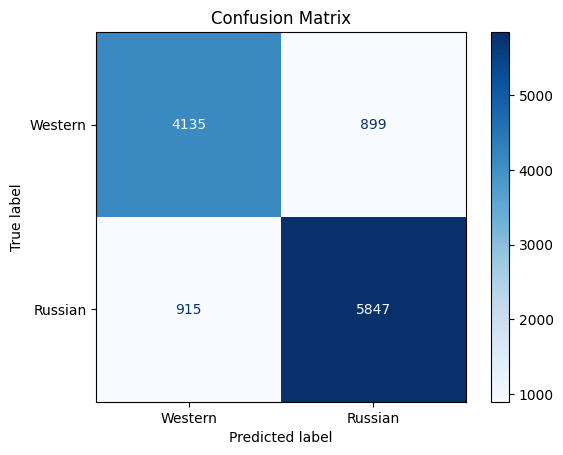

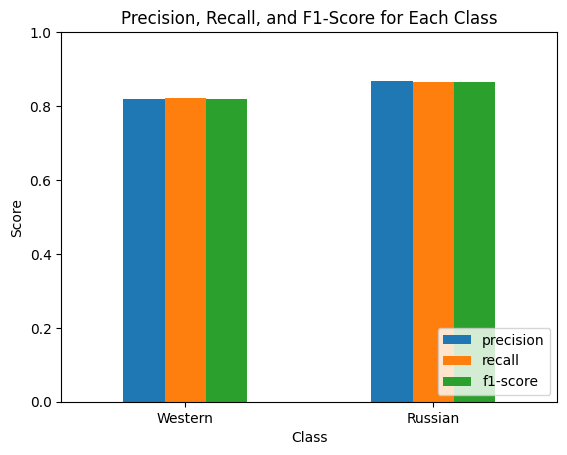

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,  RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score, roc_curve, ConfusionMatrixDisplay
import warnings

#Using the data from the combined dataset
df_combined = pd.read_csv('merged_df.csv')

#using the tweets in a column named 'tweet' and labels (binary) are in a column named 'Russian'
tweets_combined = df_combined['tweet'].tolist()
labels_combined = df_combined['Label'].tolist()

#Split the dataset intro training and test data
X_train, X_test, y_train, y_test = train_test_split(tweets_combined, labels_combined, test_size=0.3, random_state=42)

# using the TF-IDF vectorizer for the data to remove the common words making it into a matrix and handling the wording
vect_comb = TfidfVectorizer()

# Fit and transform into TF-IDF
tfidf_matrix = vect_comb.fit_transform(df_combined)

#Fit and transforming the data
X_train_tfidf = vect_comb.fit_transform(X_train)
X_test_tfidf = vect_comb.transform(X_test)

#Logistic Regression model
model = LogisticRegression(solver='saga',random_state = 42, max_iter = 100, C=10)
#using the default solver lbfgs, liblinear or saga for best results

#Training the model
model.fit(X_train_tfidf, y_train)

#Prediction of the test dataset
y_pred_comb = model.predict(X_test_tfidf)

#Evaluation of the model
accuracy = accuracy_score(y_test, y_pred_comb)
report = classification_report(y_test, y_pred_comb, output_dict=True)
print(f"Classifier Accuracy: {accuracy:.4f}")
print("Classifier Report:\n", classification_report(y_test, y_pred_comb))

#Confusion matrix plotting
conf_matrix = confusion_matrix(y_test, y_pred_comb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Western', 'Russian'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#Extract metrics
metrics_df = pd.DataFrame(report).transpose()

#Plotting based on each class the precision, recall, and F1-score
metrics_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(ticks=[0, 1], labels=['Western', 'Russian'], rotation=0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
#remove warnings
warnings.filterwarnings('ignore')

#Logistic Regression
param_grid = {
    'C': [0.1, 1, 5, 10, 20],
    'solver': ['lbfgs', 'liblinear', 'saga',],
    'max_iter': [50, 100, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
logistic_regression_model = grid_search.best_estimator_


#Conclusion on both models
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_model.predict(X_test_tfidf))

print(f"Accuracy for Logistic Regression: {logistic_regression_accuracy:.4f}")


Best parameters for Logistic Regression: {'C': 20, 'max_iter': 50, 'solver': 'saga'}
Accuracy for Logistic Regression: 0.8467


In [ ]:
warnings.filterwarnings('ignore')

X_train_tfidf = vect_comb.fit_transform(X_train)
X_test_tfidf = vect_comb.transform(X_test)


def g_search(Model, param_distributions, X_train, y_train, crossfolds=5, n_iter=10):
    # Perform randomized search
    randomized_search = RandomizedSearchCV(Model, param_distributions, cv=crossfolds, n_iter=n_iter, scoring='accuracy', random_state=42)
    randomized_search.fit(X_train, y_train)
    print("Best parameters:", randomized_search.best_params_)
    best_model = randomized_search.best_estimator_
    return best_model

def train_model(Model, X_train, y_train):
    # Fit the model
    Model.fit(X_train, y_train)
    return Model

def analyse_model(Model, Name, X_test, y_test):
    # Return classification report
    predictions = Model.predict(X_test)
    print(Name)
    print(classification_report(y_test, predictions))

def plot_lc(Model, X_train, y_train, Name):
    train_sizes, train_accuracy, test_accuracy = learning_curve(Model, X_train, y_train, cv=5)
    plt.figure()
    plt.plot(train_sizes, train_accuracy.mean(axis=1), label='Training accuracy')
    plt.plot(train_sizes, test_accuracy.mean(axis=1), label='Test accuracy')
    plt.title(f"Learning Curve for {Name}")
    plt.xlabel('Training')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'Learning Curve for {Name}.png')
    plt.clf()

def plot_roc_curve(Model, X_test, y_test, Name):
    probs = Model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve for {Name}")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'ROC Curve for {Name}.png')
    plt.clf()

def do_model(BaseModel, Name, X_train, y_train, X_test, y_test, LC=1, ROC=1):
    # Train and analyze the model
    model = train_model(BaseModel, X_train, y_train)
    analyse_model(model, Name, X_test, y_test)
    if LC == 1:
        plot_lc(model, X_train, y_train, Name)
    if ROC == 1:
        plot_roc_curve(model, X_test, y_test, Name)

# Example usage
param_distributions = [
    {'C': [0.1, 1, 10]}  # used in LR model, C = inverse regularization strength, numbers are either low C, Middle C or high C
]
logistic_regression = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
best_model = g_search(logistic_regression, param_distributions[0], X_train_tfidf, y_train)

# Perform model training and analysis
do_model(best_model, 'Logistic Regression', X_train_tfidf, y_train, X_test_tfidf, y_test)

Best parameters: {'C': 10}
Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5034
           1       0.87      0.86      0.87      6762

    accuracy                           0.85     11796
   macro avg       0.84      0.84      0.84     11796
weighted avg       0.85      0.85      0.85     11796



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Sentiment analysis

In [ ]:
import matplotlib.dates as mdates
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the DataFrame from the CSV file
merged_df = pd.read_csv('/content/merged_df.csv')

In [ ]:
value_counts = merged_df['Label'].value_counts()

# Count the Russian and Western entries
r_count = value_counts.get(1)
w_count = value_counts.get(0)
print("Russian tweets (label = 1):", r_count, ". ", "Western tweets:", w_count, "(label = 0)")

Russian tweets (label = 1): 22597 .  Western tweets: 16722 (label = 0)


In [ ]:
# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# Apply the function to the 'tweet' column
merged_df['sentiment'] = merged_df['tweet'].apply(get_sentiment)
#print(merged_df.head())

# Compare average sentiment by source
average_sentiment_by_source = merged_df.groupby('Label')['sentiment'].mean()
print(average_sentiment_by_source)

Label
0   -0.12421
1   -0.03667
Name: sentiment, dtype: float64


In [ ]:
# Split the DataFrame into two subsets based on the 'Russian' column
df_r = merged_df[merged_df['Label'] == 1]
df_w = merged_df[merged_df['Label'] == 0]

# Count positive, negative, and neutral sentiment western entries
positive_count_w = (df_w['sentiment'] >= 0.1).sum()
negative_count_w = (df_w['sentiment'] <= -0.1).sum()
neutral_count_w = w_count - negative_count_w - positive_count_w
null_count_w = (df_w['sentiment'] == 0).sum()

# Count positive, negative, and neutral sentiment western entries
positive_count_r = (df_r['sentiment'] >= 0.1).sum()
negative_count_r = (df_r['sentiment'] <= -0.1).sum()
neutral_count_r = r_count - negative_count_r - positive_count_r
null_count_r = (df_r['sentiment'] == 0).sum()

# Calculating percentage
def percentage(sentiment_count, label):

    if label == "R": percentage = round(sentiment_count*100/r_count,2)
    elif label == "W": percentage = round(sentiment_count*100/w_count,2)
    else: raise Exception('Label should be "R" or "W"')
    return percentage

positive_count_ratio_w = percentage(positive_count_w, 'W')
negative_count_ratio_w = percentage(negative_count_w, 'W')
neutral_count_ratio_w = percentage(neutral_count_w, 'W')
positive_count_ratio_r = percentage(positive_count_r, 'R')
negative_count_ratio_r = percentage(negative_count_r, 'R')
neutral_count_ratio_r = percentage(neutral_count_r, 'R')

# Print the results - Western
print("SENTIMENT ANALYSIS RESULTS FOR WESTERN TWEETS:")
print(f"Positive sentiments for Western tweets: {positive_count_w}, ({positive_count_ratio_w}% of total Western tweets)")
print(f"Negative sentiments for Western tweets: {negative_count_w}, ({negative_count_ratio_w}% of total Western tweets)")
print(f"Neutral sentiments for Western tweets: {neutral_count_w} ({neutral_count_ratio_w}% of total Western tweets), out of which {null_count_w} have sentiment equal to 0")
print(" ")

# Print the results - Russian
print("SENTIMENT ANALYSIS RESULTS FOR RUSSIAN TWEETS:")
print(f"Positive sentiments for Russian tweets: {positive_count_r}, ({positive_count_ratio_r}% of total Russian tweets)")
print(f"Negative sentiments for Russian tweets: {negative_count_r}, ({negative_count_ratio_r}% of total Russian tweets")
print(f"Neutral sentiments for Russian tweets: {neutral_count_r} ({neutral_count_ratio_r}% of total Russian tweets), out of which {null_count_r} have sentiment equal to 0")


SENTIMENT ANALYSIS RESULTS FOR WESTERN TWEETS:
Positive sentiments for Western tweets: 3468, (20.74% of total Western tweets)
Negative sentiments for Western tweets: 6648, (39.76% of total Western tweets)
Neutral sentiments for Western tweets: 6606 (39.5% of total Western tweets), out of which 6082 have sentiment equal to 0
 
SENTIMENT ANALYSIS RESULTS FOR RUSSIAN TWEETS:
Positive sentiments for Russian tweets: 6582, (29.13% of total Russian tweets)
Negative sentiments for Russian tweets: 7708, (34.11% of total Russian tweets
Neutral sentiments for Russian tweets: 8307 (36.76% of total Russian tweets), out of which 7672 have sentiment equal to 0


   Percentage (%)   Region               Sentiment
0           20.74  Western         Positive (>0.1)
1           39.50  Western  Neutral (>-0.1 & <0.1)
2           29.13  Russian         Positive (>0.1)
3           34.11  Russian        Negative (<-0.1)
4           36.76  Russian  Neutral (>-0.1 & <0.1)
5           39.76  Western        Negative (<-0.1)


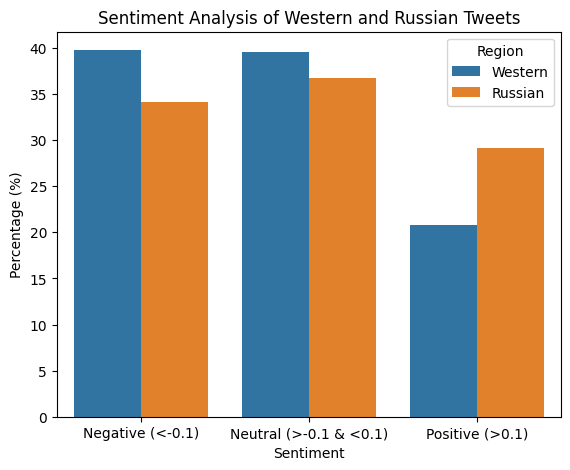

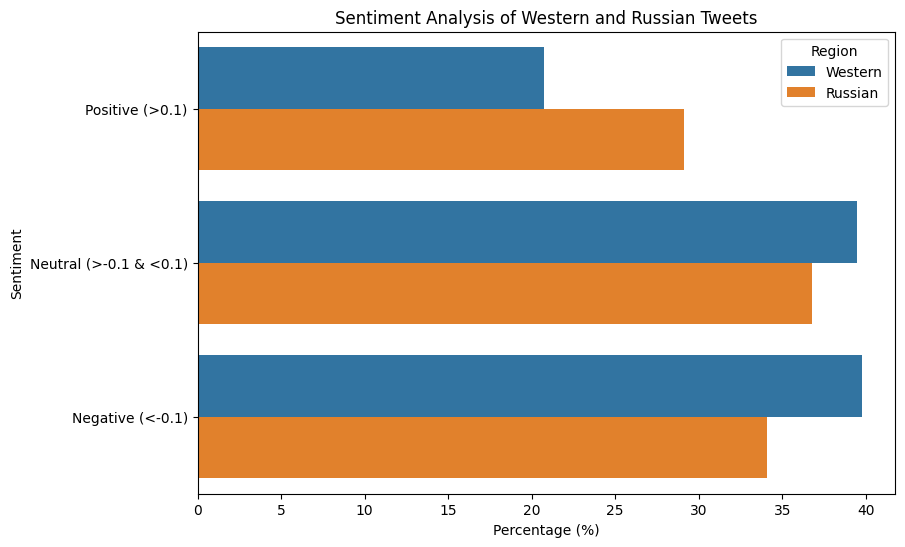

In [ ]:
ratios_dict = {
    'Percentage (%)': [positive_count_ratio_w, neutral_count_ratio_w, positive_count_ratio_r, negative_count_ratio_r, neutral_count_ratio_r, negative_count_ratio_w],
    'Region': ["Western","Western","Russian", "Russian", "Russian","Western"],
    'Sentiment': ["Positive (>0.1)", 'Neutral (>-0.1 & <0.1)',"Positive (>0.1)", 'Negative (<-0.1)', 'Neutral (>-0.1 & <0.1)', 'Negative (<-0.1)']
}

# Create the DataFrame
ratios = pd.DataFrame(ratios_dict)
print(ratios)

# Define the order of sentiments for inversion
order = ['Negative (<-0.1)', 'Neutral (>-0.1 & <0.1)', 'Positive (>0.1)']
# Create a bar plot
plt.figure(figsize=(6.5, 5))
sns.barplot(x='Sentiment', y='Percentage (%)', hue='Region', data=ratios, order=order)
# Add titles and labels
plt.title('Sentiment Analysis of Western and Russian Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.legend(title='Region')
# Show the plot
plt.show()


# Create a bar plot
plt.figure(figsize=(9, 6))
sns.barplot(y='Sentiment', x='Percentage (%)', hue='Region', data=ratios)
# Add titles and labels
plt.title('Sentiment Analysis of Western and Russian Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Percentage (%)')
plt.legend(title='Region')
# Show the plot
plt.show()


## Correlation between sentiment, likes and retweets
### (All the tweets)

In [ ]:
# Defining a function that plots correlation between sentiment and either likes or retweets
def plot_sentiment_corr(data, y, title):

    if y == 'likes_count':
        ylabel = 'Likes'
    elif y == 'retweets_count':
        ylabel = 'Retweets'
    else:
        raise ValueError("y must be either 'likes_count' or 'retweets_count'")
    plt.figure(figsize=(10, 2.5))
    sns.scatterplot(data = data, y = y, x='sentiment')
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = merged_df[['sentiment', 'likes_count', 'retweets_count']].corr()

# Print the correlation matrix
print("Correlation matrix for sentiment, likes and retweets in all tweets:")
print(correlation_matrix)

# Plotting the correlation between sentiment and likes or retweets
#plot_sentiment_corr(merged_df, 'likes_count', 'Sentiment vs Likes')
#plot_sentiment_corr(merged_df, 'retweets_count', 'Sentiment vs Retweets')


Correlation matrix for sentiment, likes and retweets in all tweets:
                sentiment  likes_count  retweets_count
sentiment        1.000000    -0.074314       -0.096404
likes_count     -0.074314     1.000000        0.925305
retweets_count  -0.096404     0.925305        1.000000


## Correlation between sentiment, likes and retweets
### (Tweets divided by Western and Russian)

Correlation matrix for Russian tweets:
                sentiment  likes_count  retweets_count
sentiment        1.000000    -0.067474       -0.068634
likes_count     -0.067474     1.000000        0.932402
retweets_count  -0.068634     0.932402        1.000000

Correlation matrix for Western Tweets:
                sentiment  likes_count  retweets_count
sentiment        1.000000    -0.073875       -0.107109
likes_count     -0.073875     1.000000        0.923198
retweets_count  -0.107109     0.923198        1.000000


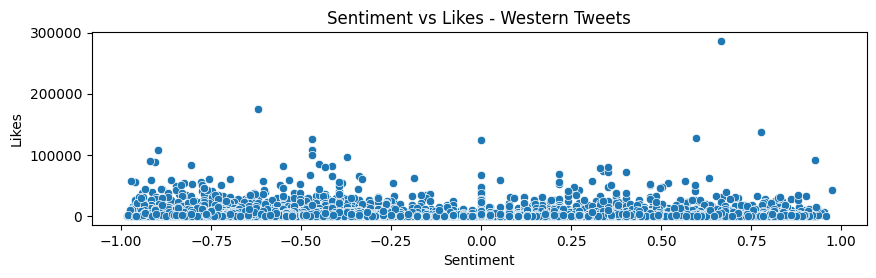

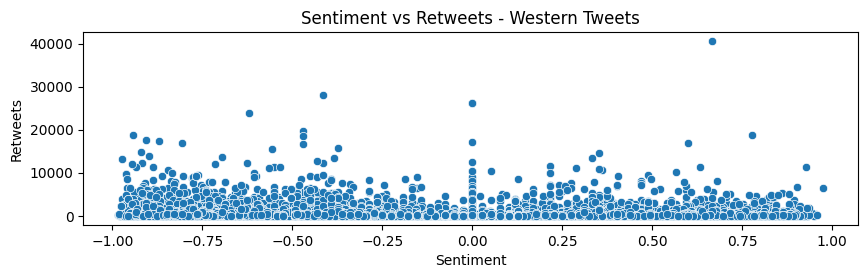

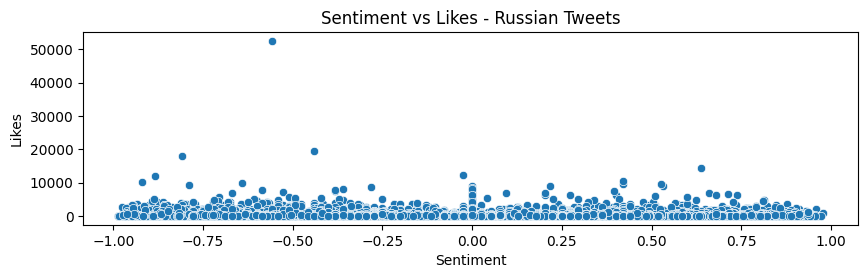

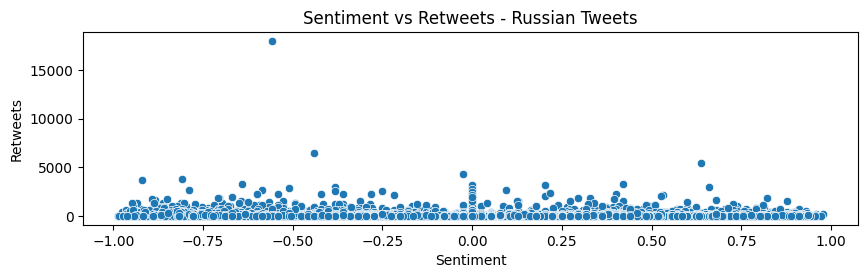

In [ ]:
# Calculate the correlation for each subset
correlation_russian = df_r[['sentiment', 'likes_count', 'retweets_count']].corr()
correlation_western = df_w[['sentiment', 'likes_count', 'retweets_count']].corr()

# Display the correlation matrices
print("Correlation matrix for Russian tweets:")
print(correlation_russian)
print("\nCorrelation matrix for Western Tweets:")
print(correlation_western)

# Visualize the relationships using scatter plots, for Western and Russian tweets
plot_sentiment_corr(df_w, 'likes_count', 'Sentiment vs Likes - Western Tweets')
plot_sentiment_corr(df_w, 'retweets_count', 'Sentiment vs Retweets - Western Tweets')
plot_sentiment_corr(df_r, 'likes_count', 'Sentiment vs Likes - Russian Tweets')
plot_sentiment_corr(df_r, 'retweets_count', 'Sentiment vs Retweets - Russian Tweets')

Correlation matrix for Russian tweets (absolute value of sentiment):
                sentiment  likes_count  retweets_count
sentiment        1.000000     0.084115        0.076985
likes_count      0.084115     1.000000        0.932402
retweets_count   0.076985     0.932402        1.000000

Correlation matrix for Western Tweets (absolute value of sentiment):
                sentiment  likes_count  retweets_count
sentiment        1.000000     0.163647        0.183429
likes_count      0.163647     1.000000        0.923198
retweets_count   0.183429     0.923198        1.000000


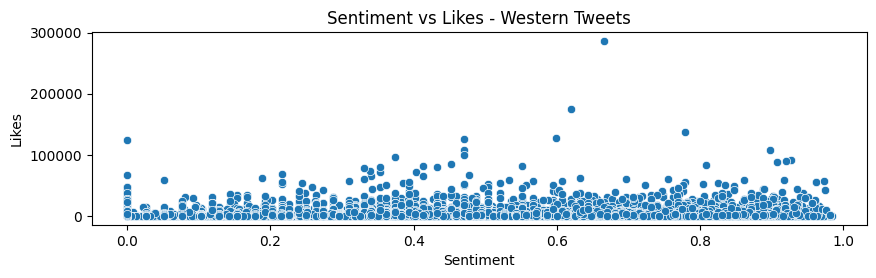

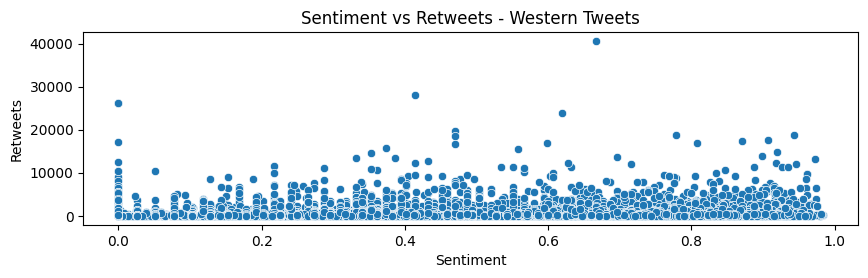

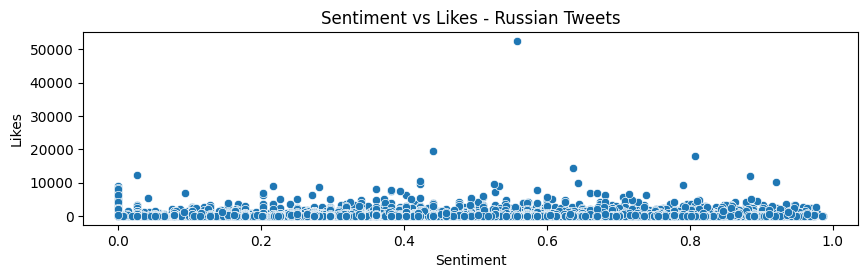

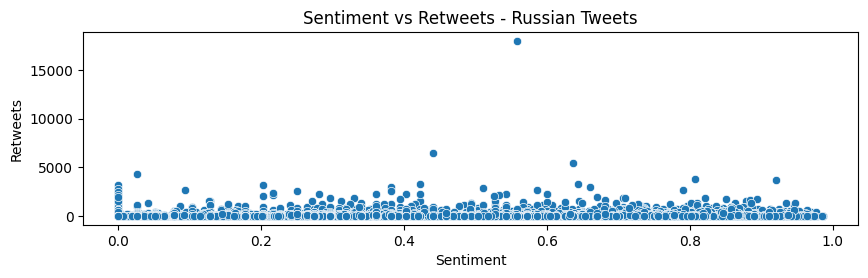

In [ ]:
# Create copies of the DataFrames
df_w_copy = df_w.copy()
df_r_copy = df_r.copy()

# Apply absolute operation on the 'sentiment' column of the copied DataFrames
df_w_copy['sentiment'] = df_w_copy['sentiment'].abs()
df_r_copy['sentiment'] = df_r_copy['sentiment'].abs()

# Calculate the correlation for each subset
correlation_russian = df_r_copy[['sentiment', 'likes_count', 'retweets_count']].corr()
correlation_western = df_w_copy[['sentiment', 'likes_count', 'retweets_count']].corr()

# Correlation matrix for absolute value of sentiment
print("Correlation matrix for Russian tweets (absolute value of sentiment):")
print(correlation_russian)
print("\nCorrelation matrix for Western Tweets (absolute value of sentiment):")
print(correlation_western)

# Visualize the relationships using scatter plots, for Western and Russian tweets
plot_sentiment_corr(df_w_copy, 'likes_count', 'Sentiment (absolute value) vs Likes - Western Tweets')
plot_sentiment_corr(df_w_copy, 'retweets_count', 'Sentiment  (absolute value) vs Retweets - Western Tweets')
plot_sentiment_corr(df_r_copy, 'likes_count', 'Sentiment  (absolute value) vs Likes - Russian Tweets')
plot_sentiment_corr(df_r_copy, 'retweets_count', 'Sentiment  (absolute value) vs Retweets - Russian Tweets')

## Russian tweets:
**Sentiment vs. Likes Count:** The correlation coefficient between sentiment and likes count is -0.067490. This is a very weak negative correlation, suggesting that there is almost no relationship between the sentiment of the tweets and the number of likes they receive.

**Sentiment vs. Retweets Count:** The correlation coefficient between sentiment and retweets count is -0.068646, which is also a very weak negative correlation. This indicates that the sentiment of the tweets has almost no effect on the number of retweets.

**Likes Count vs. Retweets Count:** The correlation between likes count and retweets count is 0.932403, which is a very strong positive correlation. This implies that tweets that receive more likes tend to also receive more retweets.

## Western tweets:
**Sentiment vs. Likes Count:** The correlation coefficient between sentiment and likes count is -0.073812. Similar to the Russian tweets, this is a very weak negative correlation, indicating almost no relationship between the sentiment of the tweets and the number of likes.

**Sentiment vs. Retweets Count:** The correlation coefficient between sentiment and retweets count is -0.107043, which is still a weak negative correlation but slightly stronger than that observed in Russian tweets. This suggests a slight tendency for tweets with more negative sentiment to receive fewer retweets.

**Likes Count vs. Retweets Count:** The correlation between likes count and retweets count is 0.923216, which is a very strong positive correlation. This means that, similar to Russian tweets, Western tweets that receive more likes also tend to receive more retweets.

## Summary:
**Sentiment Correlation:** For both Russian and Western tweets, the sentiment shows very weak negative correlations with both likes and retweets. This indicates that the sentiment of the tweet (whether positive or negative) does not significantly impact its popularity in terms of likes and retweets.

**Likes and Retweets Relationship:** There is a very strong positive correlation between likes and retweets for both Russian and Western tweets. Tweets that are liked more are also retweeted more, suggesting that overall engagement metrics (likes and retweets) are closely related regardless of the sentiment or the source.

These results imply that while the sentiment of a tweet is not a strong predictor of engagement in terms of likes and retweets, the overall engagement metrics are highly interrelated. This information could be useful in understanding user interaction patterns on social media platforms.









## Evolution of average sentiment in all tweets

In [ ]:
# Define a function that creates a line plot to visualize the average sentiment over some dates
def plot_sentiment_change(data, title, color):
    plt.figure(figsize=(10, 3))
    data.plot(kind='line', marker='o', color=color)
    plt.title(title)
    plt.xlabel('date')
    plt.ylabel('Average Sentiment')
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    plt.grid(True)
    plt.show()

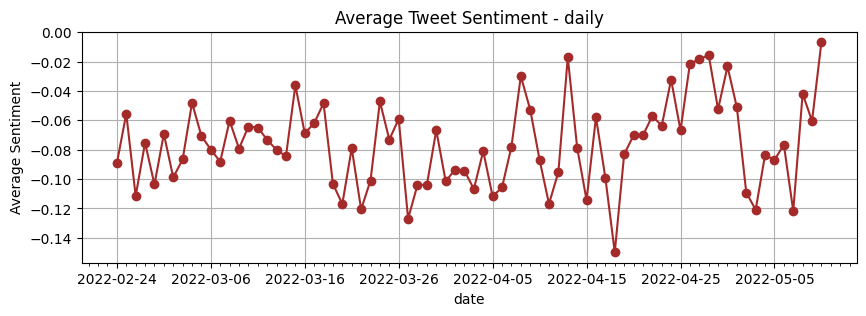

In [ ]:
# Group by month and calculate the average sentiment for each month
average_sentiment = merged_df.groupby('date')['sentiment'].mean()
# print(average_sentiment)
# Visualise graph
plot_sentiment_change(average_sentiment, "Average Tweet Sentiment - daily", "brown")

date
2022-02-24   -0.117980
2022-02-25   -0.058482
2022-02-26   -0.154490
2022-02-27   -0.102162
2022-02-28   -0.126499
                ...   
2022-05-06   -0.063504
2022-05-07   -0.174121
2022-05-08   -0.107347
2022-05-09   -0.198741
2022-05-10   -0.153784
Name: sentiment, Length: 76, dtype: float64


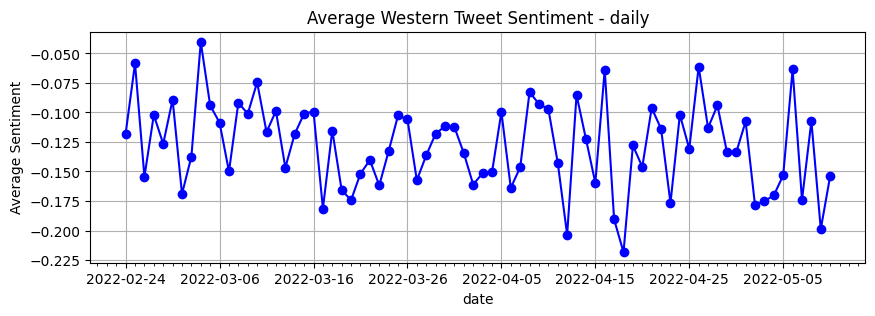

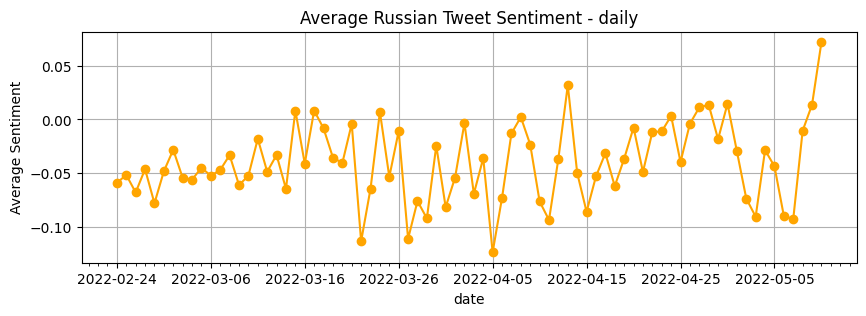

In [ ]:
# Group by month and calculate the average sentiment for each month
average_sentiment_w = df_w.groupby('date')['sentiment'].mean()
average_sentiment_r = df_r.groupby('date')['sentiment'].mean()
print(average_sentiment_w)
# print(average_sentiment_r)

# Create a line plot to visualize the average Western and Russian tweet sentiment over time
plot_sentiment_change(average_sentiment_w, "Average Western Tweet Sentiment - daily","b")
plot_sentiment_change(average_sentiment_r, "Average Russian Tweet Sentiment - daily","orange")

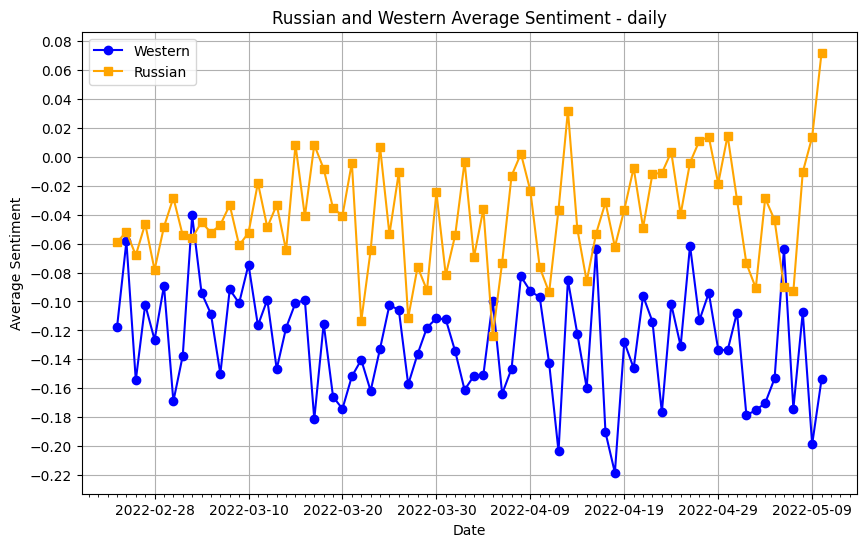

In [ ]:
plt.figure(figsize=(10, 6))
# Plot two time series
plt.plot(average_sentiment_w, label='Western', color='blue', marker='o')
plt.plot(average_sentiment_r, label='Russian', color='orange', marker='s')
# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Russian and Western Average Sentiment - daily')
plt.legend()
# Set x-axis major and minor locator
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# Setting y-axis ticks limits and interval
plt.yticks(np.arange(0.08, -0.23, -0.02))
# Show plot
plt.grid(True)
plt.show()

In [ ]:
avg_sent_noindex_r = average_sentiment_r.reset_index()
avg_sent_noindex_r.rename(columns={'sentiment': 'sentiment_r'}, inplace=True)
avg_sent_noindex_w = average_sentiment_w.reset_index()
avg_sent_noindex_w.rename(columns={'sentiment': 'sentiment_w'}, inplace=True)
# Merging data about currecencies and Russian sentiment
avg_sent_corr = pd.merge(avg_sent_noindex_w, avg_sent_noindex_r, on='date')
# Calculate the correlation matrix
correlation_matrix_wr = avg_sent_corr[['sentiment_w', 'sentiment_r']].corr()
print("Correlation matrix between Russian and Western sentiment:")
# Print the correlation matrix
print(correlation_matrix_wr)

Correlation matrix between Russian and Western sentiment:
             sentiment_w  sentiment_r
sentiment_w     1.000000     0.028708
sentiment_r     0.028708     1.000000


In [ ]:
# Load the DataFrame from the CSV file
exchange_df = pd.read_csv('rouble_exchange_rates.csv')

# Merging data about currecencies and Russian sentiment
sent_ex_r = average_sentiment_r.reset_index()
sent_ex_r = pd.merge(average_sentiment_r, exchange_df, on='date')
# Calculate the correlation matrix
correlation_matrix_r = sent_ex_r[['sentiment', 'rub_eur','rub_usd','rub_gbp']].corr()
# Print the correlation matrix
print("Correlation matrix for Russian sentiment and exchange rates:")
print(correlation_matrix_r)



# Merging data about currecencies and Western sentiment
sent_ex_w = average_sentiment_w.reset_index()
sent_ex_w = pd.merge(sent_ex_w, exchange_df, on='date')
# Calculate the correlation matrix
correlation_matrix_w = sent_ex_w[['sentiment', 'rub_eur','rub_usd','rub_gbp']].corr()

# Print the correlation matrix
print("\nCorrelation matrix for Western sentiment and exchange rates:")
print(correlation_matrix_w)

Correlation matrix for Russian sentiment and exchange rates:
           sentiment   rub_eur   rub_usd   rub_gbp
sentiment   1.000000  0.120976  0.117524  0.126339
rub_eur     0.120976  1.000000  0.994148  0.999212
rub_usd     0.117524  0.994148  1.000000  0.993552
rub_gbp     0.126339  0.999212  0.993552  1.000000

Correlation matrix for Western sentiment and exchange rates:
           sentiment   rub_eur   rub_usd   rub_gbp
sentiment   1.000000 -0.110521 -0.102082 -0.112193
rub_eur    -0.110521  1.000000  0.994148  0.999212
rub_usd    -0.102082  0.994148  1.000000  0.993552
rub_gbp    -0.112193  0.999212  0.993552  1.000000


# Dynamic Topic Modelling

## Installing the necessary packages and Loading data

In [ ]:
%pip install bertopic
%pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [ ]:
from bertopic import BERTopic


In [ ]:
# Load the data
df_r = pd.read_csv('df_r.csv')
df_w = pd.read_csv('df_w.csv')

## BERTopic Models

To analyze the MoM evolution of the topics covered in both Russian and Western tweets, we will use both LDA and BERT, and further compare the results. We will group tweets by month to have a representative overview that is not too computationally intensive (in terms of processing capacity and running time).

### BERTopic for Dynamic Topic Modelling - Russian Tweets

In [ ]:
# BERT Model for Dynamic Topic Modelling - Russian tweets
timestamps = df_r["date"].to_list()
tweets_text_r = df_r["cleaned_tokens"].to_list()

dtm_bert_r = BERTopic(verbose=True)  # to have an overview of how the model is running
topics_r, probs_r = dtm_bert_r.fit_transform(tweets_text_r)

topics_over_time_r = dtm_bert_r.topics_over_time(tweets_text_r, timestamps)

2024-05-28 11:22:45,804 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/707 [00:00<?, ?it/s]

2024-05-28 11:33:15,632 - BERTopic - Embedding - Completed ✓
2024-05-28 11:33:15,634 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-28 11:34:17,713 - BERTopic - Dimensionality - Completed ✓
2024-05-28 11:34:17,715 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-28 11:34:26,737 - BERTopic - Cluster - Completed ✓
2024-05-28 11:34:26,784 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-28 11:34:30,322 - BERTopic - Representation - Completed ✓
76it [00:18,  4.21it/s]


In [ ]:
filtered_topics_over_time_r = topics_over_time_r[
    topics_over_time_r["Topic"].isin(range(1, 12))
]

In [ ]:
# Visualizing the evolution of topics in Russian tweets over time
fig_r = dtm_bert_r.visualize_topics_over_time(
    filtered_topics_over_time_r, top_n_topics=6
)

# Adding a title to the visualization
fig_r.update_layout(title_text="Evolution of Topics in Russian Tweets Over Time")
fig_r.show()

In [ ]:
# Printing the top 10 topics with their respective words and weights:
def print_top_topics(model, num_topics=12):
    topic_info = model.get_topic_info()
    top_topic_ids = topic_info.head(num_topics)["Topic"].tolist()

    for topic_id in top_topic_ids:
        topic = model.get_topic(topic_id)
        words_weights = ', '.join([f"{word}: {weight:.4f}" for word, weight in topic])
        print(f"Topic {topic_id}: {words_weights}")
        print("")

print_top_topics(dtm_bert_r, num_topics=12)

Topic -1: people: 0.0037, force: 0.0034, time: 0.0033, civilian: 0.0032, city: 0.0032, country: 0.0031, military: 0.0031, mariupol: 0.0031, think: 0.0031, west: 0.0031

Topic 0: : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000, : 0.0000

Topic 1: nazi: 0.0325, liberal: 0.0169, fascist: 0.0141, democrat: 0.0131, trump: 0.0111, nazism: 0.0107, supporting: 0.0106, support: 0.0101, fascism: 0.0096, people: 0.0090

Topic 2: kiev: 0.0752, regime: 0.0168, ghost: 0.0127, minsk: 0.0097, force: 0.0075, agreement: 0.0063, region: 0.0062, attack: 0.0061, military: 0.0060, donbas: 0.0057

Topic 3: dollar: 0.0390, currency: 0.0349, price: 0.0337, gold: 0.0260, bank: 0.0254, inflation: 0.0247, ruble: 0.0245, energy: 0.0213, reserve: 0.0186, payment: 0.0168

Topic 4: good: 0.0470, lying: 0.0466, nice: 0.0341, correct: 0.0320, indeed: 0.0316, lie: 0.0277, kinda: 0.0267, yeah: 0.0252, okay: 0.0249, true: 0.0249

Topic 5: putin: 0.0849, vladimir: 0.0470, president:

### BERTopic for Dynamic Topic Modelling - Western Tweets

In [ ]:
# BERT Model for Dynamic Topic Modelling - Western tweets
timestamps = df_w["date"].to_list()
tweets_text_w = df_w["cleaned_tokens"].to_list()

dtm_bert_w = BERTopic(verbose=True)  # to have an overview of how the model is running
topics_w, probs_w = dtm_bert_w.fit_transform(tweets_text_w)

topics_over_time_w = dtm_bert_w.topics_over_time(tweets_text_w, timestamps)

2024-05-28 11:35:13,606 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/523 [00:00<?, ?it/s]

2024-05-28 11:44:10,201 - BERTopic - Embedding - Completed ✓
2024-05-28 11:44:10,207 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-28 11:44:31,222 - BERTopic - Dimensionality - Completed ✓
2024-05-28 11:44:31,224 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-28 11:44:36,320 - BERTopic - Cluster - Completed ✓
2024-05-28 11:44:36,339 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-28 11:44:37,217 - BERTopic - Representation - Completed ✓
76it [00:09,  7.74it/s]


In [ ]:
filtered_topics_over_time_w = topics_over_time_w[
    topics_over_time_w["Topic"].isin(range(1, 12))
]

In [ ]:
# Visualizing the evolution of topics in Western tweets over time
fig_w = dtm_bert_w.visualize_topics_over_time(
    filtered_topics_over_time_w, top_n_topics=6
)

# Adding a title to the visualization
fig_w.update_layout(title_text="Evolution of Topics in Western Tweets Over Time")
fig_w.show()

In [ ]:
# Printing the top 10 topics with their respective words and weights:
def print_top_topics(model, num_topics=12):
    topic_info = model.get_topic_info()
    top_topic_ids = topic_info.head(num_topics)["Topic"].tolist()

    for topic_id in top_topic_ids:
        topic = model.get_topic(topic_id)
        words_weights = ', '.join([f"{word}: {weight:.4f}" for word, weight in topic])
        print(f"Topic {topic_id}: {words_weights}")
        print("")

print_top_topics(dtm_bert_w, num_topics=12)